Just fiddling with a simple GAN.

In [2]:
# thingies we want
import numpy as np
import scipy.stats as stats
import scipy.linalg as la
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
import matplotlib.pyplot as plt

# pretties
%matplotlib inline
plt.style.use('ggplot')

Using TensorFlow backend.


In [3]:
def generate_real_data(n, d=2):
    """
    Sample some data from an awkward distribution
    """
    
    # Sample a point on the (d-1)-sphere
    u = stats.multivariate_normal.rvs(mean=np.zeros(d), cov=np.identity(d), size=n)
    u /= la.norm(u)
    
    # Restrict it to one quadrant
    u *= np.sign(u)
    
    # Sample some unrelated magnitude
    e = stats.expon.rvs(size=n)

    return u * e[:, np.newaxis]

In [257]:
def plot_data(data):
    """
    Plot the (first two dimensions of the) data
    """
    
    fig = plt.figure(figsize=(15,4))
    
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.plot(data[:, 0], data[:, 1], '.')
    ax1.set_xlim([-0.05, 0.25])
    ax1.set_ylim([-0.05, 0.25])
    
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.hist(la.norm(data, axis=1), bins=30)
    ax2.set_xlim([0, 0.4])
    
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.hist(np.arctan2(data[:, 0], data[:, 1]), bins=30)
    ax3.set_xlim([-np.pi, np.pi])

    return fig

In [258]:
# Data constants
d = 2
n = 1000

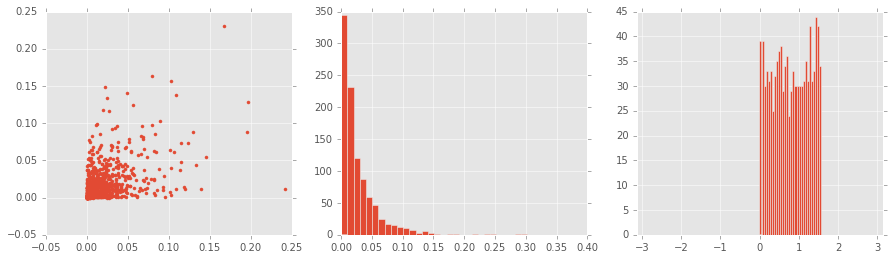

In [295]:
plot_data(generate_real_data(n, d=d))
plt.show()

In [99]:
def switch_trainable(network, trainable):
    network.trainable = trainable
    for layer in network.layers:
       layer.trainable = trainable

In [ ]:
noise_gen = stats.multivariate_normal(mean=np.zeros(d), cov=np.identity(d))

In [299]:
def build_generator(d=2):
    model = Sequential()
    model.add(Dense(units=32, activation='relu', input_dim=d))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=d, activation='linear'))
    return model

def build_discriminator(d=2):
    model = Sequential()
    model.add(Dense(units=32, activation='relu', input_dim=d))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))
    return model

In [300]:
generator = build_generator(d=d)

discriminator = build_discriminator(d=d)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer='sgd',
    metrics=['accuracy'])

adversarial = Sequential()
adversarial.add(generator)
adversarial.add(discriminator)
adversarial.compile(
    loss='binary_crossentropy',
    optimizer='sgd',
    metrics=['accuracy'])

In [301]:
# Warm up the discriminator
noise = noise_gen.rvs(size=n)
x_batch = np.concatenate((generate_real_data(n, d=d), noise), axis=0)
y_batch = np.concatenate((np.ones(n), np.zeros(n)), axis=0)
discriminator.fit(x_batch, y_batch, epochs=10)

Epoch 1/10
2000/2000 [==============================] - 1s 263us/step - loss: 0.6673 - acc: 0.9410
Epoch 2/10
2000/2000 [==============================] - 0s 46us/step - loss: 0.6379 - acc: 0.9775
Epoch 3/10
2000/2000 [==============================] - 0s 45us/step - loss: 0.6064 - acc: 0.9730
Epoch 4/10
2000/2000 [==============================] - 0s 57us/step - loss: 0.5726 - acc: 0.9645
Epoch 5/10
2000/2000 [==============================] - 0s 48us/step - loss: 0.5355 - acc: 0.9625
Epoch 6/10
2000/2000 [==============================] - 0s 46us/step - loss: 0.4953 - acc: 0.9605
Epoch 7/10
2000/2000 [==============================] - 0s 49us/step - loss: 0.4528 - acc: 0.9600
Epoch 8/10
2000/2000 [==============================] - 0s 49us/step - loss: 0.4100 - acc: 0.9600
Epoch 9/10
2000/2000 [==============================] - 0s 47us/step - loss: 0.3687 - acc: 0.9590
Epoch 10/10
2000/2000 [==============================] - 0s 47us/step - loss: 0.3291 - acc: 0.9585


/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


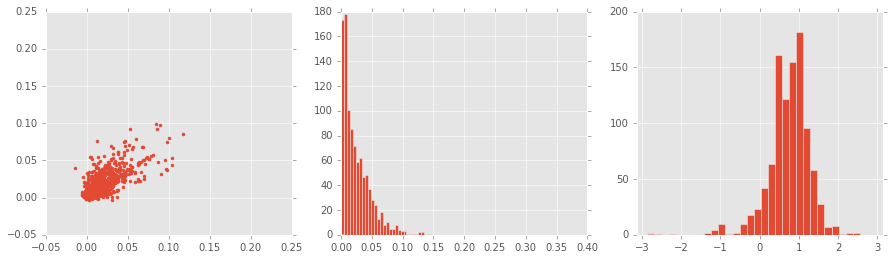

In [358]:
# Train
num_it = 50

for it in range(num_it):
    
    # Sample from generator
    fakes = generator.predict(noise_gen.rvs(size=n))
    
    # Update discriminator
    x_batch = np.concatenate((generate_real_data(n, d=d), fakes), axis=0)
    y_batch = np.concatenate((np.ones(n), np.zeros(n)), axis=0)
    discriminator.train_on_batch(x_batch, y_batch)
    
    # Update generator
    switch_trainable(discriminator, False)
    adversarial.train_on_batch(noise_gen.rvs(size=n), np.ones(n))
    switch_trainable(discriminator, True)
    
fake_data = generator.predict(noise_gen.rvs(size=n))

plot_data(fake_data)
plt.show()